# Business Filings in NYC, Brooklyn, and Red Hook

This notebook relies on data from the "Legally Operating Businesses" dataset posted on NYC Open data:

https://data.cityofnewyork.us/Business/Legally-Operating-Businesses/w7w3-xahh

It contains historical information on business filings in NYC including the business type and location. 

In [1]:
import urllib.request
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from fiona.crs import from_epsg
import matplotlib.pylab as plt
import numpy as np
import copy

In [2]:
business_filings = pd.read_csv('data/primary_source_data/business_filings.csv')
business_filings.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location
0,0959361-DCA,Business,03/31/2021,Active,04/25/1997,Garage,"PARKANLEX GARAGE COMPANY, LLC",NaN,115,E 75TH ST,...,108.0,4.0,1.04314e+06,1014100011,MN40,128.0,"Vehicle Spaces: 165, Bicycle Spaces: 17",-73.961625,40.772737,"(40.7727369020104, -73.96162515178469)"
1,1235988-DCA,Business,02/28/2021,Active,08/15/2006,Home Improvement Contractor,"JUNIOR'S IRONWORK & CONSTRUCTION, INC.",NaN,16927,LIBERTY AVE,...,412.0,27.0,4e+06,4102180032,QN61,444.0,NaN,-73.788915,40.703297,"(40.70329689832498, -73.78891454010119)"
2,1453298-DCA,Individual,05/31/2019,Active,01/07/2013,Locksmith,"RAO, GARY PETER",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2049399-DCA,Business,12/31/2020,Active,03/09/2017,Electronics Store,"CANAL ALARM DEVICES, INC.",NaN,387,CANAL ST,...,102.0,1.0,1.00294e+06,1002270004,MN24,47.0,NaN,-74.004791,40.721466,"(40.721465796925365, -74.00479091086221)"
4,2021443-DCA,Business,03/31/2021,Active,04/21/2015,Garage and Parking Lot,O & A PARKING GARAGE INC.,NaN,1100,FRANKLIN AVE,...,NaN,NaN,NaN,NaN,BX35,185.0,"Vehicle Spaces: 36, Bicycle Spaces: 10",NaN,NaN,NaN


In [3]:
# Remove rows for filings with Address Borough listed as "Outside NYC"
nyc_filings = business_filings[business_filings['Address Borough']!='Outside NYC']

In [4]:
# Drop "Location" column since it is improperly formatted
nyc_filings.drop(['Location'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
# Convert creation date to datetime
nyc_filings['License Creation Date'] = pd.to_datetime(nyc_filings['License Creation Date'], \
                                                           format='%m/%d/%Y')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
print("Total number of business filings in all of NYC: {}".format(nyc_filings.shape[0]))

Total number of business filings in all of NYC: 184145


## Grouping by date for NYC

In [7]:
# All filings in NYC
filings_date_groups = nyc_filings.set_index('License Creation Date')
filings_date_groups.head()

,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,Secondary Address Street Name,...,Borough Code,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude
License Creation Date,,,,,,,,,,,,,,,,,,,,,
1997-04-25,0959361-DCA,Business,03/31/2021,Active,Garage,"PARKANLEX GARAGE COMPANY, LLC",NaN,115,E 75TH ST,NaN,...,1.0,108.0,4.0,1.04314e+06,1014100011,MN40,128.0,"Vehicle Spaces: 165, Bicycle Spaces: 17",-73.961625,40.772737
2006-08-15,1235988-DCA,Business,02/28/2021,Active,Home Improvement Contractor,"JUNIOR'S IRONWORK & CONSTRUCTION, INC.",NaN,16927,LIBERTY AVE,NaN,...,4.0,412.0,27.0,4e+06,4102180032,QN61,444.0,NaN,-73.788915,40.703297
2013-01-07,1453298-DCA,Individual,05/31/2019,Active,Locksmith,"RAO, GARY PETER",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-09,2049399-DCA,Business,12/31/2020,Active,Electronics Store,"CANAL ALARM DEVICES, INC.",NaN,387,CANAL ST,NaN,...,1.0,102.0,1.0,1.00294e+06,1002270004,MN24,47.0,NaN,-74.004791,40.721466
2015-04-21,2021443-DCA,Business,03/31/2021,Active,Garage and Parking Lot,O & A PARKING GARAGE INC.,NaN,1100,FRANKLIN AVE,NaN,...,2.0,NaN,NaN,NaN,NaN,BX35,185.0,"Vehicle Spaces: 36, Bicycle Spaces: 10",NaN,NaN


In [8]:
# Grouping all filings by the month of the creation date and taking the count of each column
filings_count = filings_date_groups.resample('M').count()
filings_count.reset_index(inplace=True)
filings_count['Year'] = filings_count['License Creation Date'].dt.year
filings_count['Year'].astype(int, inplace=True)
filings_count.head()

,License Creation Date,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Year
0,1977-01-31,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1977
1,1977-02-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1977
2,1977-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1977
3,1977-04-30,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1977
4,1977-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1977


## For normalization by population

In [9]:
# Set a multiplier for the normalized fields since they will otherwise be very small
norm_multiplier_pop = 1

In [10]:
# Population data over time
pop_df = pd.read_csv('data/created_data/pop_time.csv')
pop_df

,Year,New York County,Kings County,Bronx County,Queens County,Richmond County,New York City Total,Red Hook CTs
0,2010,1583345,2466782,1365725,2199169,463450,8078471,10973
1,2011,1588257,2486119,1374593,2213977,466034,8128980,11374
2,2012,1596735,2512740,1386364,2235008,468374,8199221,10987
3,2013,1605272,2539789,1397315,2256400,470223,8268999,10670
4,2014,1618398,2570801,1413566,2280602,471522,8354889,10440
5,2015,1629507,2595259,1428357,2301139,472481,8426743,10768
6,2016,1634989,2606852,1436785,2310011,473324,8461961,11102
7,2017,1653877,2635121,1455846,2339280,475948,8560072,11316


In [11]:
# Merge the two
file_count_merge = filings_count.merge(pop_df, how='left', left_on='Year', right_on='Year')
file_count_merge.head()

,License Creation Date,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Longitude,Latitude,Year,New York County,Kings County,Bronx County,Queens County,Richmond County,New York City Total,Red Hook CTs
0,1977-01-31,1,1,1,1,1,1,1,1,1,...,1,1,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1977-02-28,0,0,0,0,0,0,0,0,0,...,0,0,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1977-03-31,0,0,0,0,0,0,0,0,0,...,0,0,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1977-04-30,1,1,1,1,1,1,1,1,1,...,1,1,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1977-05-31,0,0,0,0,0,0,0,0,0,...,0,0,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
file_count_merge[file_count_merge['Year']==2017]

,License Creation Date,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Longitude,Latitude,Year,New York County,Kings County,Bronx County,Queens County,Richmond County,New York City Total,Red Hook CTs
480,2017-01-31,858,858,858,858,858,858,97,547,547,...,544,544,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
481,2017-02-28,800,800,800,800,800,800,92,428,430,...,424,424,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
482,2017-03-31,1262,1262,1262,1262,1262,1261,187,688,691,...,683,683,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
483,2017-04-30,1197,1197,1197,1197,1197,1196,119,667,669,...,659,659,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
484,2017-05-31,1082,1082,1082,1082,1082,1082,162,578,584,...,578,578,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
485,2017-06-30,1103,1103,1103,1103,1103,1103,145,583,585,...,581,581,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
486,2017-07-31,936,936,936,936,936,936,107,496,503,...,498,498,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
487,2017-08-31,978,978,978,978,978,977,124,553,557,...,550,550,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
488,2017-09-30,860,860,860,860,860,859,108,494,495,...,490,490,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0
489,2017-10-31,1063,1063,1063,1063,1063,1063,171,740,742,...,734,734,2017,1653877.0,2635121.0,1455846.0,2339280.0,475948.0,8560072.0,11316.0


In [13]:
# Get the normalized count
file_count_merge['count_norm_pop'] = file_count_merge['DCA License Number']/ \
    file_count_merge['New York City Total']*norm_multiplier_pop

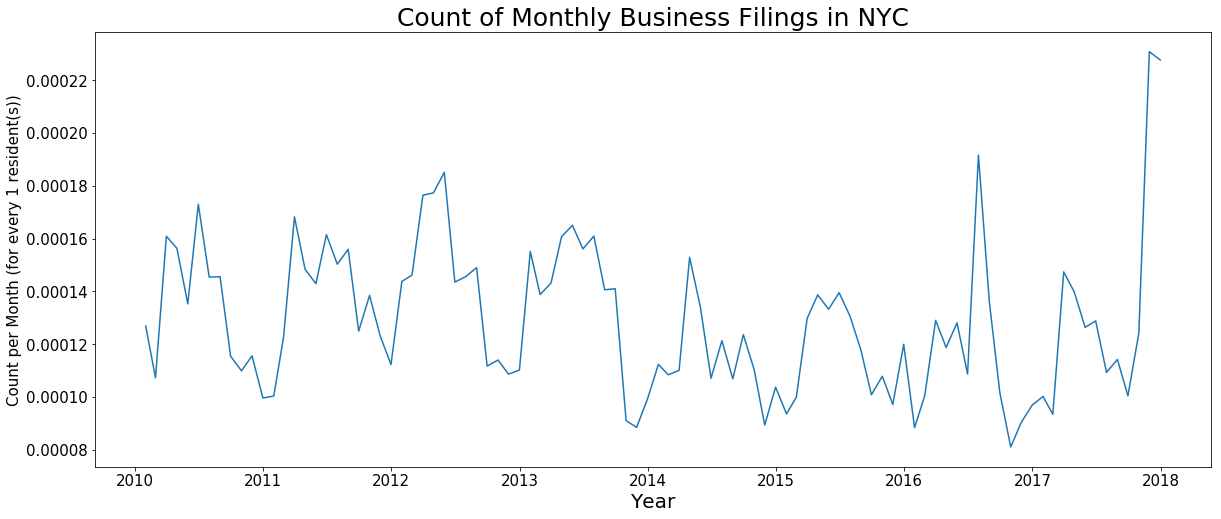

In [14]:
# Plot
plt.figure(figsize=(20,8))
plt.plot(file_count_merge['License Creation Date'], file_count_merge['count_norm_pop'])
plt.title("Count of Monthly Business Filings in NYC", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Count per Month (for every {} resident(s))".format(norm_multiplier_pop), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Business Filings for Brooklyn only

In [15]:
# Create a Brooklyn df
bk_df = nyc_filings[(nyc_filings['Address Borough']=='Brooklyn') | (nyc_filings['Address Borough']=='BROOKLYN')]

In [16]:
# Repeat the steps above
bk_date_groups = bk_df.set_index('License Creation Date')
bk_count = bk_date_groups.resample('M').count()
bk_count.reset_index(inplace=True)
bk_count['Year'] = bk_count['License Creation Date'].dt.year
bk_merge = pd.merge(bk_count, pop_df[['Kings County', 'Red Hook CTs', 'Year']], how='left', \
                    left_on='Year', right_on='Year')
bk_merge['count_norm_pop'] = bk_merge['DCA License Number']/bk_merge['Kings County']*norm_multiplier_pop
bk_merge.head()

,License Creation Date,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Year,Kings County,Red Hook CTs,count_norm_pop
0,1977-01-31,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1977,NaN,NaN,NaN
1,1977-02-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1977,NaN,NaN,NaN
2,1977-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1977,NaN,NaN,NaN
3,1977-04-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1977,NaN,NaN,NaN
4,1977-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1977,NaN,NaN,NaN


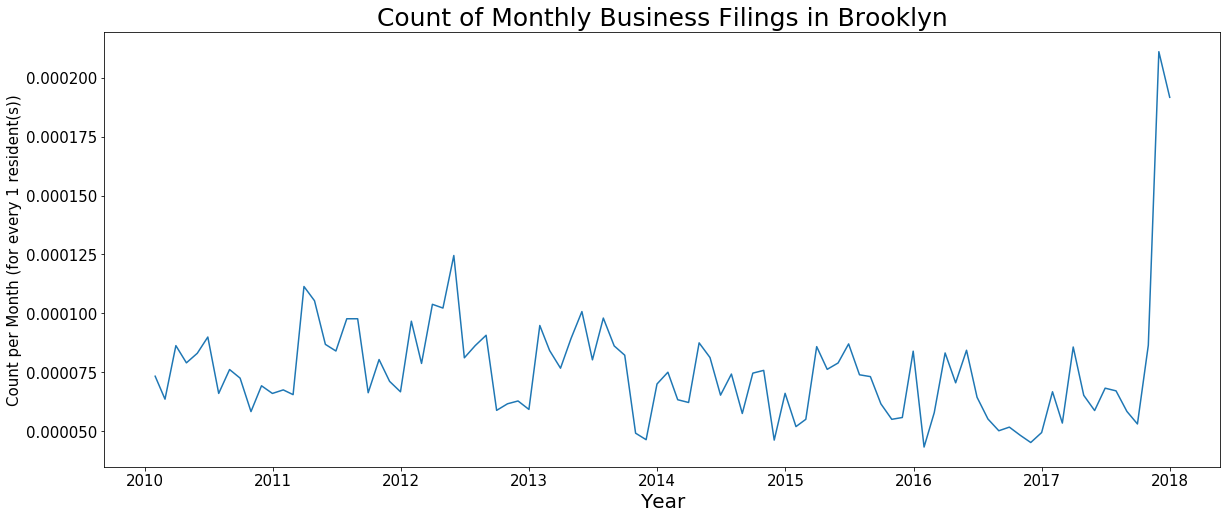

In [17]:
# Plot
plt.figure(figsize=(20,8))
plt.plot(bk_merge['License Creation Date'], bk_merge['count_norm_pop'])
plt.title("Count of Monthly Business Filings in Brooklyn", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Count per Month (for every {} resident(s))".format(norm_multiplier_pop), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

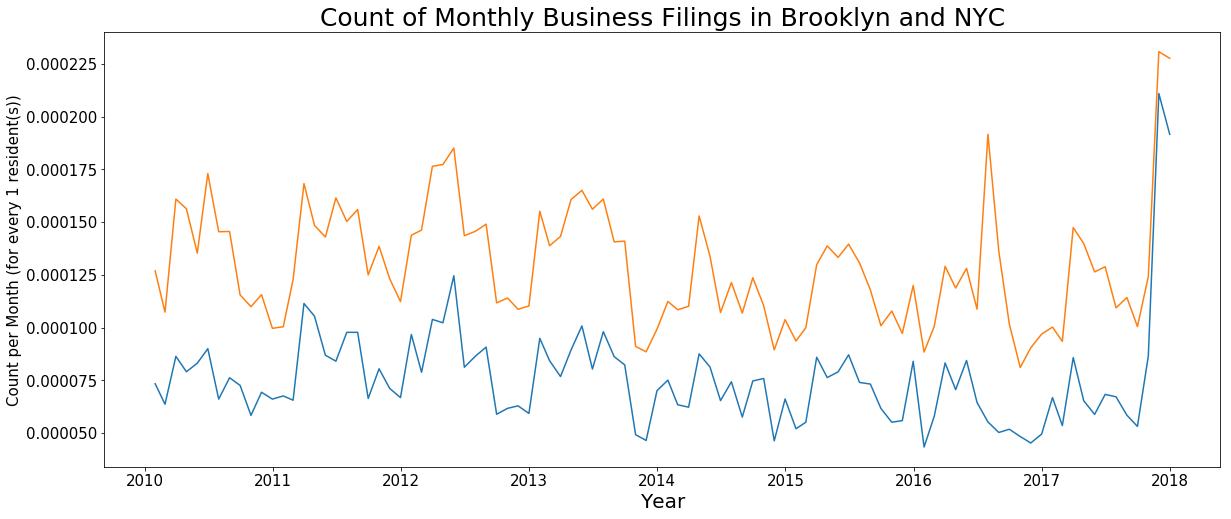

In [18]:
# Brooklyn and all of NYC
plt.figure(figsize=(20,8))
plt.plot(bk_merge['License Creation Date'], bk_merge['count_norm_pop'], label='Brooklyn')
plt.plot(file_count_merge['License Creation Date'], file_count_merge['count_norm_pop'], label='NYC')
plt.title("Count of Monthly Business Filings in Brooklyn and NYC", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Count per Month (for every {} resident(s))".format(norm_multiplier_pop), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Business Filings for Red Hook only

In [19]:
rh_tracts = gpd.read_file('data/created_data/rh_comb_tract/rh_comb_tract.shp')
rh_tracts

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,geometry
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,"POLYGON ((982904.2286376971 189083.8547973089,..."


In [20]:
# Make a copy for Red Hook only
rh_df = copy.deepcopy(nyc_filings)

In [21]:
# Remove rows with null lat lon data
rh_df = rh_df[rh_df['Longitude'].notnull()]
rh_df['lonlat'] = list(zip(rh_df.Longitude, rh_df.Latitude))

In [22]:
# Make a geodataframe
rh_df = gpd.GeoDataFrame(rh_df)
rh_df.crs = from_epsg(4326)
rh_df['geometry'] = rh_df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [23]:
rh_df.head()

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,lonlat,geometry
0,0959361-DCA,Business,03/31/2021,Active,1997-04-25,Garage,"PARKANLEX GARAGE COMPANY, LLC",NaN,115,E 75TH ST,...,4.0,1.04314e+06,1014100011,MN40,128.0,"Vehicle Spaces: 165, Bicycle Spaces: 17",-73.961625,40.772737,"(-73.96162515178469, 40.7727369020104)",POINT (-73.96162515178469 40.7727369020104)
1,1235988-DCA,Business,02/28/2021,Active,2006-08-15,Home Improvement Contractor,"JUNIOR'S IRONWORK & CONSTRUCTION, INC.",NaN,16927,LIBERTY AVE,...,27.0,4e+06,4102180032,QN61,444.0,NaN,-73.788915,40.703297,"(-73.78891454010119, 40.70329689832498)",POINT (-73.78891454010119 40.70329689832498)
3,2049399-DCA,Business,12/31/2020,Active,2017-03-09,Electronics Store,"CANAL ALARM DEVICES, INC.",NaN,387,CANAL ST,...,1.0,1.00294e+06,1002270004,MN24,47.0,NaN,-74.004791,40.721466,"(-74.00479091086221, 40.721465796925365)",POINT (-74.00479091086221 40.72146579692537)
5,2071799-DCA,Business,02/28/2019,Inactive,2018-05-24,Home Improvement Contractor,148 HUA HONG INC,NaN,2011,W 13TH ST,...,47.0,3.1908e+06,3070930077,BK29,402.0,NaN,-73.984430,40.597747,"(-73.98442958280751, 40.59774665777339)",POINT (-73.98442958280751 40.59774665777339)
8,1363927-DCA,Business,02/28/2021,Active,2010-07-26,Home Improvement Contractor,PATRICK C. VENTRUDO,VENTRUDO CUSTOM HOME RENOVATIONS,271,ROLLING HILL GRN,...,51.0,5.11886e+06,5060177502,SI48,17010.0,NaN,-74.193665,40.551543,"(-74.1936645467115, 40.55154307629882)",POINT (-74.1936645467115 40.55154307629882)


In [24]:
# Match CRS
rh_df = rh_df.to_crs(epsg=2263)

In [25]:
# Join with the Red Hook census tract to keep only business filings within the neighborhood
rh_df_sjoin = gpd.tools.sjoin(rh_df,rh_tracts)

/anaconda3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [26]:
# Bring in more data for plotting
rh_centroid = gpd.read_file('data/created_data/rh_centroid/rh_centroid.shp')
site_poly = gpd.read_file('data/created_data/site/site_poly/site_poly.shp')
site_centroid = gpd.read_file('data/created_data/site/site_centroid/site_centroid.shp')

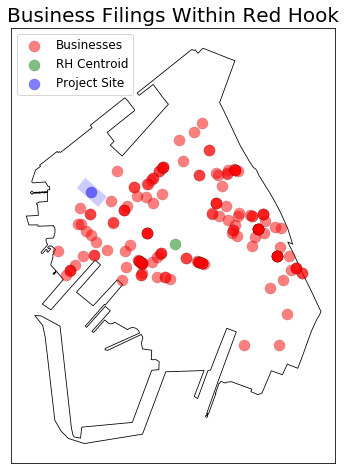

In [27]:
# Plot
f, ax = plt.subplots(figsize=(8,8))
rh_tracts.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
rh_df_sjoin.plot(alpha=.5, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=125, label='Businesses')
rh_centroid.plot(alpha=.5, linewidth=0.2,ax=ax,color='g',edgecolor='black',markersize=125,label='RH Centroid')
site_poly.plot(alpha=.2, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=100)
site_centroid.plot(alpha=.5, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=125, \
                   label='Project Site')
plt.title("Business Filings Within Red Hook", fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.legend(fontsize=12, loc='upper left')
plt.show()

In [28]:
# Number of business filings in Red Hook
rh_df_sjoin.shape

(157, 39)

In [29]:
# Red Hook groups
rh_date_groups = rh_df_sjoin.set_index('License Creation Date')
rh_date_groups.head()

,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,Secondary Address Street Name,...,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng
License Creation Date,,,,,,,,,,,,,,,,,,,,,
2010-11-09,1376498-DCA,Business,02/28/2021,Active,Home Improvement Contractor,"A T CONCEPT, INC.",NaN,601,COURT ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2007-10-05,1269827-DCA,Business,02/28/2019,Inactive,Home Improvement Contractor,"PREMIUM MILLWORK, INC.",NaN,43,COFFEY ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2019-01-07,2081179-1-DCA,Business,12/31/2019,Active,Tobacco Retail Dealer,MP LORRAINE CORP.,NaN,58,LORRAINE ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2016-06-23,2039389-DCA,Business,02/28/2021,Active,Home Improvement Contractor,CLEARVIEW SM INC,NaN,199,BUSH ST,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2013-09-23,1474193-DCA,Business,02/28/2021,Active,Home Improvement Contractor,360 INTERIOR CONCEPT HOLDINGS CORP.,NaN,360,HAMILTON AVE,NaN,...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705


In [30]:
# Grouping all filings by the month of the creation date and taking the count of each column
rh_count = rh_date_groups.resample('M').count()
rh_count.reset_index(inplace=True)
rh_count['Year'] = rh_count['License Creation Date'].dt.year
rh_merge = pd.merge(rh_count, pop_df[['Red Hook CTs', 'Year']], how='left', \
                    left_on='Year', right_on='Year')
rh_merge['count_norm_pop'] = rh_merge['DCA License Number']/rh_merge['Red Hook CTs']*norm_multiplier_pop
rh_merge.head()

,License Creation Date,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,Year,Red Hook CTs,count_norm_pop
0,1998-04-30,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1998,NaN,NaN
1,1998-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,NaN,NaN
2,1998-06-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,NaN,NaN
3,1998-07-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,NaN,NaN
4,1998-08-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,NaN,NaN


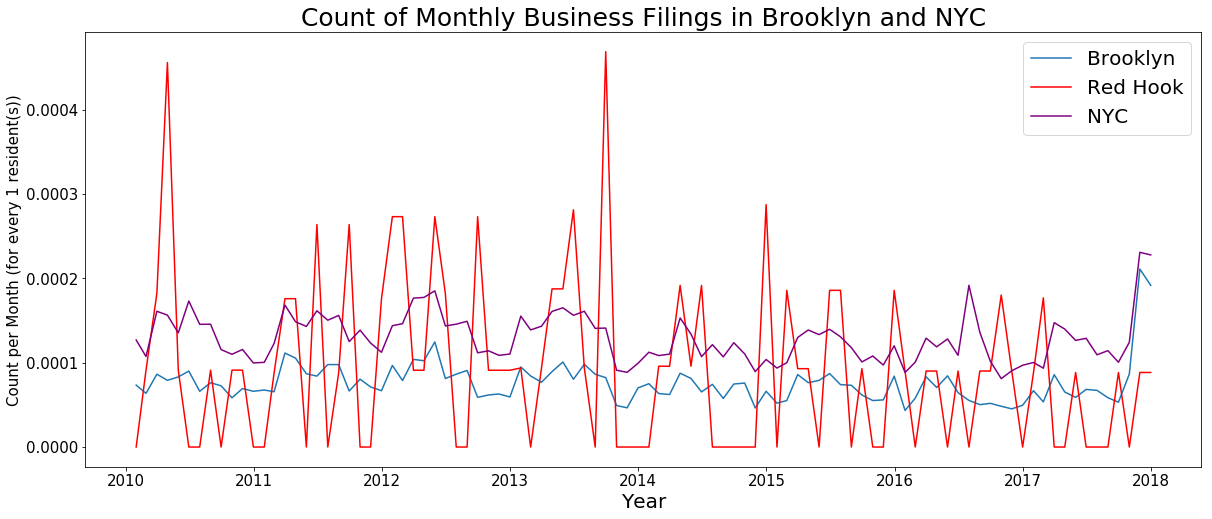

In [31]:
# Brooklyn and all of NYC
plt.figure(figsize=(20,8))
plt.plot(bk_merge['License Creation Date'], bk_merge['count_norm_pop'], label='Brooklyn')
plt.plot(rh_merge['License Creation Date'], rh_merge['count_norm_pop'], c='r', label='Red Hook')
plt.plot(file_count_merge['License Creation Date'], file_count_merge['count_norm_pop'], c='purple', label='NYC')
plt.title("Count of Monthly Business Filings in Brooklyn and NYC", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Count per Month (for every {} resident(s))".format(norm_multiplier_pop), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Descriptive stats

This data set is somewhat confusing because it includes the information for vendors across the country who have filed to operate in NYC. So the address information in this data set includes other locations outside NYC. It may be difficult to establish exactly how many business filings are related to Red Hook.

For now, I will use a simple spatial join with our combined Red Hook cesus tracts to get an initial sense of the number of business filings within Red Hook.

In [32]:
# Number of rows missing borough info
print(nyc_filings['Address Borough'].isnull().sum())

70414


In [33]:
# Number of rows missing city info (note that this column is less useful since it includes places beyond NYC)
print(nyc_filings['Address City'].isnull().sum())

710


In [34]:
# Number of rows missing lat lon
print(nyc_filings['Longitude'].isnull().sum())
print(nyc_filings['Latitude'].isnull().sum())

70523
70523


## Business filings by industry

In [35]:
# All unique industry names for filings across NYC
industries = set(rh_df['Industry'].values)
industries

{'Amusement Arcade',
 'Amusement Device Permanent',
 'Amusement Device Portable',
 'Amusement Device Temporary',
 'Auction House Premises',
 'Bingo Game Operator',
 'Booting Company',
 'Cabaret',
 'Car Wash',
 'Catering Establishment',
 'Commercial Lessor',
 'Dealer In Products',
 'Debt Collection Agency',
 'Electronic & Appliance Service',
 'Electronic Cigarette Dealer',
 'Electronics Store',
 'Employment Agency',
 'Games of Chance',
 'Gaming Cafe',
 'Garage',
 'Garage and Parking Lot',
 'General Vendor Distributor',
 'Home Improvement Contractor',
 'Horse Drawn Cab Owner',
 'Laundries',
 'Laundry',
 'Laundry Jobber',
 'Newsstand',
 'Parking Lot',
 'Pawnbroker',
 'Pedicab Business',
 'Pool or Billiard Room',
 'Process Serving Agency',
 'Scale Dealer Repairer',
 'Scrap Metal Processor',
 'Secondhand Dealer - Auto',
 'Secondhand Dealer - Firearms',
 'Secondhand Dealer - General',
 'Sidewalk Cafe',
 'Sightseeing Bus',
 'Special Sale',
 'Stoop Line Stand',
 'Storage Warehouse',
 'Ticket S

In [36]:
# All unique industry names for filings in Red Hook
rh_industries = set(rh_df['Industry'].values)
rh_industries

{'Amusement Arcade',
 'Amusement Device Permanent',
 'Amusement Device Portable',
 'Amusement Device Temporary',
 'Auction House Premises',
 'Bingo Game Operator',
 'Booting Company',
 'Cabaret',
 'Car Wash',
 'Catering Establishment',
 'Commercial Lessor',
 'Dealer In Products',
 'Debt Collection Agency',
 'Electronic & Appliance Service',
 'Electronic Cigarette Dealer',
 'Electronics Store',
 'Employment Agency',
 'Games of Chance',
 'Gaming Cafe',
 'Garage',
 'Garage and Parking Lot',
 'General Vendor Distributor',
 'Home Improvement Contractor',
 'Horse Drawn Cab Owner',
 'Laundries',
 'Laundry',
 'Laundry Jobber',
 'Newsstand',
 'Parking Lot',
 'Pawnbroker',
 'Pedicab Business',
 'Pool or Billiard Room',
 'Process Serving Agency',
 'Scale Dealer Repairer',
 'Scrap Metal Processor',
 'Secondhand Dealer - Auto',
 'Secondhand Dealer - Firearms',
 'Secondhand Dealer - General',
 'Sidewalk Cafe',
 'Sightseeing Bus',
 'Special Sale',
 'Stoop Line Stand',
 'Storage Warehouse',
 'Ticket S

In [37]:
# Get a dictionary of individual dfs with counts for the total filings of each industry in Red Hook
def industry_group_maker(industry_list):
    industry_dfs = {}
    for industry in industry_list:
        temp_df = rh_df[rh_df['Industry']==industry]
        temp_df = temp_df.set_index('License Creation Date')
        temp_df = temp_df.resample('M').count()
        temp_df = temp_df[temp_df.index.year>=2010]
        industry_dfs[industry] = industry_dfs.get(industry, temp_df)
    return industry_dfs

In [38]:
# Get all the individualized industry dataframes for Red Hook
all_rh_industry_dfs = industry_group_maker(rh_industries)

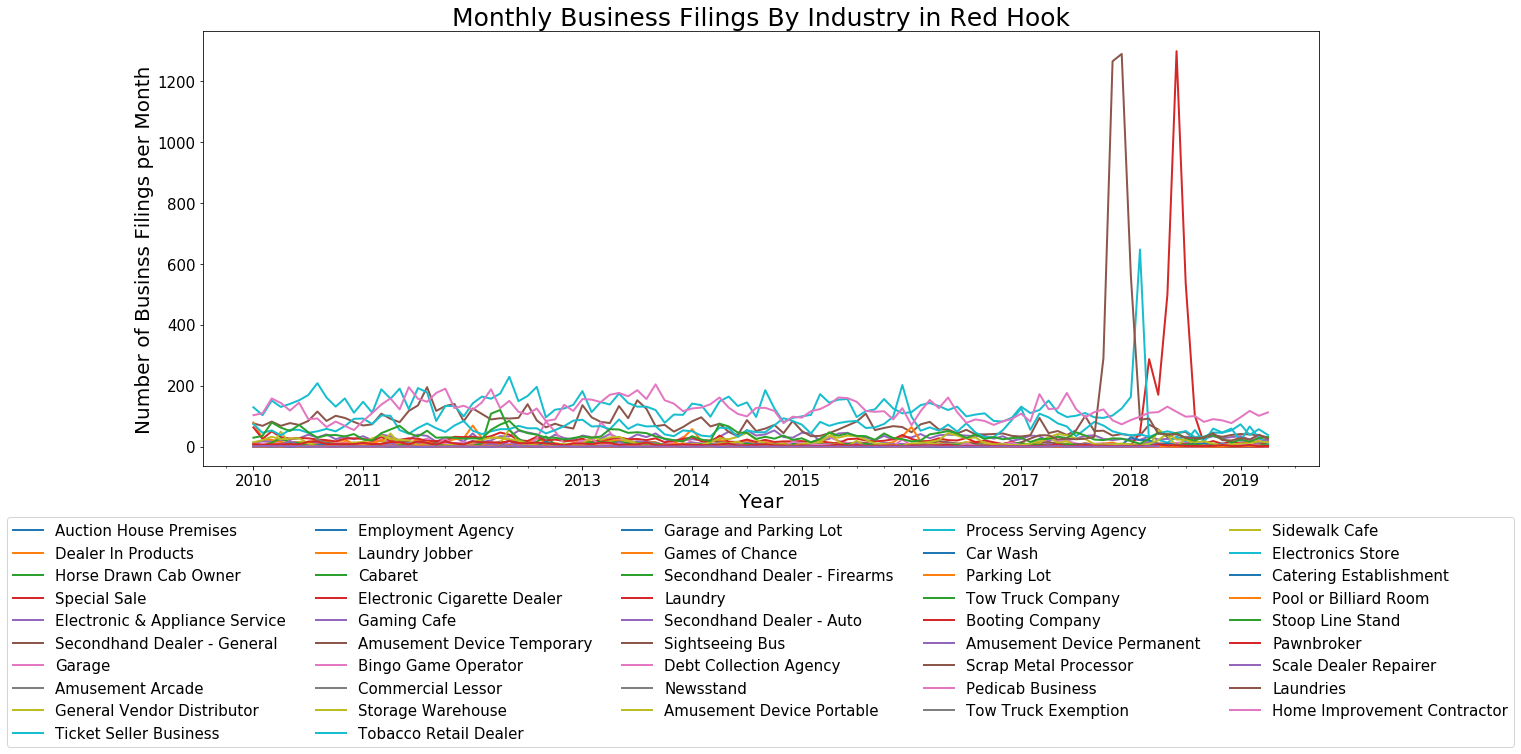

In [39]:
# Set earliest year to view:
f, ax = plt.subplots(figsize=(20,8))
for k,v in all_rh_industry_dfs.items():
    v['DCA License Number'].plot(alpha=1,linewidth=2,ax=ax,label=k)
plt.title("Monthly Business Filings By Industry in Red Hook", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Businss Filings per Month", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=5,fontsize=15)
plt.show()

In [40]:
# Getting the top industries (for all time) since the previous plot is confusing
top_industries = {}
for k,v in all_rh_industry_dfs.items():
    top_industries[k] = top_industries.get(k, (v['DCA License Number'].sum(), v))
top_industries = sorted(top_industries.items(), key=lambda x: x[1][0], reverse=True)

In [41]:
# Set the number of top industries you want
cutoff = 5

In [42]:
print("Top {} industries and total number of filings since 2010:".format(cutoff))
print("")
for i in range(cutoff):
    print(str(top_industries[i][0]) + " - " + str(top_industries[i][1][0]))
    print("")

Top 5 industries and total number of filings since 2010:

Tobacco Retail Dealer - 13954

Home Improvement Contractor - 13565

Secondhand Dealer - General - 7970

Electronics Store - 6948

Laundries - 4238



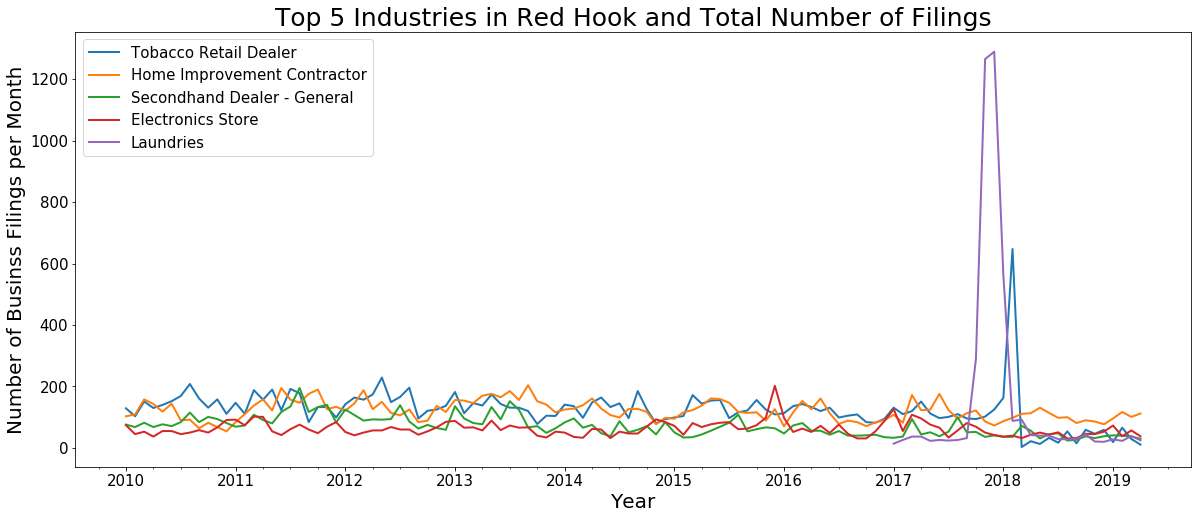

In [44]:
plt.figure(figsize=(20,8))
for i in range(cutoff):
    top_industries[i][1][1]['DCA License Number'].plot(alpha=1,linewidth=2, \
                                                       label=top_industries[i][0])
plt.title("Top {} Industries in Red Hook and Total Number of Filings".format(cutoff), fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Businss Filings per Month", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.show()

### Note:

The above plot shows the top industries in Red Hook between 2010 and 2019. The top industries were found by taking those with the overall largest count of business filings between 2010 and 2019.

In [45]:
# Removing laundries since it may be an outlier
top_ind_edit = {}
for k,v in all_rh_industry_dfs.items():
    if k != 'Laundries':
        top_ind_edit[k] = top_ind_edit.get(k, (v['DCA License Number'].sum(), v))
top_ind_edit = sorted(top_ind_edit.items(), key=lambda x: x[1][0], reverse=True)

In [46]:
print("Top {} industries and total number of filings since 2010:".format(cutoff))
print("")
for i in range(cutoff):
    print(str(top_ind_edit[i][0]) + " - " + str(top_ind_edit[i][1][0]))
    print("")

Top 5 industries and total number of filings since 2010:

Tobacco Retail Dealer - 13954

Home Improvement Contractor - 13565

Secondhand Dealer - General - 7970

Electronics Store - 6948

Stoop Line Stand - 3940



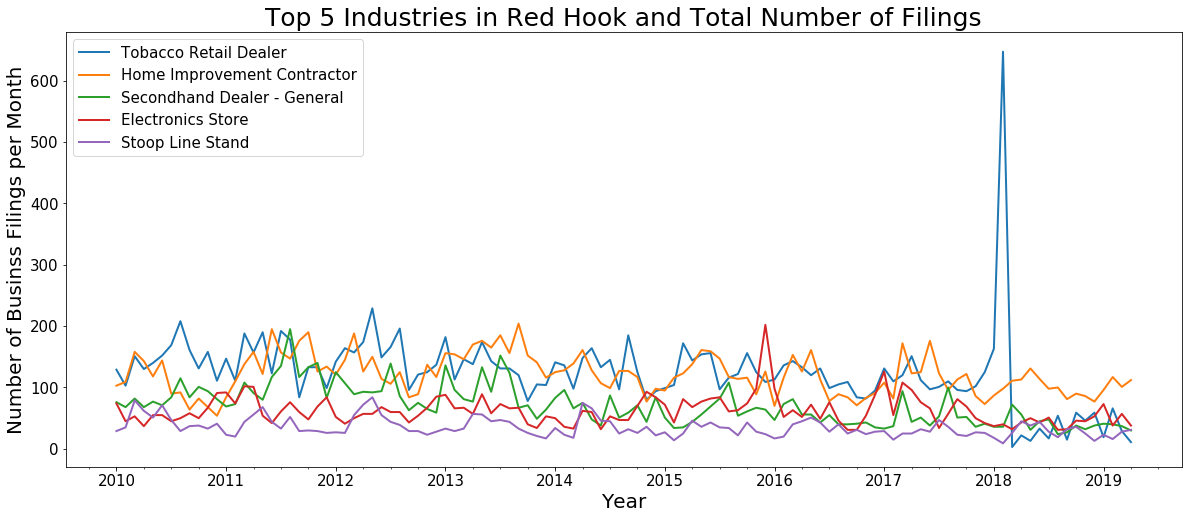

In [47]:
plt.figure(figsize=(20,8))
for i in range(cutoff):
    top_ind_edit[i][1][1]['DCA License Number'].plot(alpha=1,linewidth=2, \
                                                       label=top_ind_edit[i][0])
plt.title("Top {} Industries in Red Hook and Total Number of Filings".format(cutoff), fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Businss Filings per Month", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.show()

## Normalization by area

In [48]:
# Can use this to make the filings count normalized by shape area larger
norm_mult_area = 1

In [49]:
# Pull in the census tracts to get shape areas
nyc_cts = gpd.read_file('data/primary_source_data/census_tracts/geo_export_a1169309-1083-403c-8f43-' + \
                        '77f62e2a399e.shp')
nyc_cts = nyc_cts.to_crs(epsg=2263)
nyc_cts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375973 173705.5001830519,..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.5070190424 214848.8975829605,..."
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861348 216013.1307982849,..."
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845678 216507.687011669, ..."
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((991325.8815917961 217001.6885985838,..."


In [50]:
# Get total area of NYC
nyc_tot_area = nyc_cts.shape_area.sum()
nyc_tot_area

8429404878.812349

In [51]:
# Get total area of Brooklyn
bk_tot_area = nyc_cts[nyc_cts['boro_name']=='Brooklyn'].shape_area.sum()
rh_tot_area = rh_tracts.shape_area.values[0]

In [52]:
# Normalize the filings for all of NYC
file_count_merge['count_norm_area'] = file_count_merge['DCA License Number']/nyc_tot_area*norm_mult_area
file_count_merge.head()

,License Creation Date,DCA License Number,License Type,License Expiration Date,License Status,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Year,New York County,Kings County,Bronx County,Queens County,Richmond County,New York City Total,Red Hook CTs,count_norm_pop,count_norm_area
0,1977-01-31,1,1,1,1,1,1,1,1,1,...,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.186323e-10
1,1977-02-28,0,0,0,0,0,0,0,0,0,...,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
2,1977-03-31,0,0,0,0,0,0,0,0,0,...,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
3,1977-04-30,1,1,1,1,1,1,1,1,1,...,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.186323e-10
4,1977-05-31,0,0,0,0,0,0,0,0,0,...,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [53]:
# Normalize the filings for Brooklyn and Red Hook
bk_merge['count_norm_area'] = bk_merge['DCA License Number']/bk_tot_area*norm_mult_area
rh_merge['count_norm_area'] = rh_merge['DCA License Number']/rh_tot_area*norm_mult_area

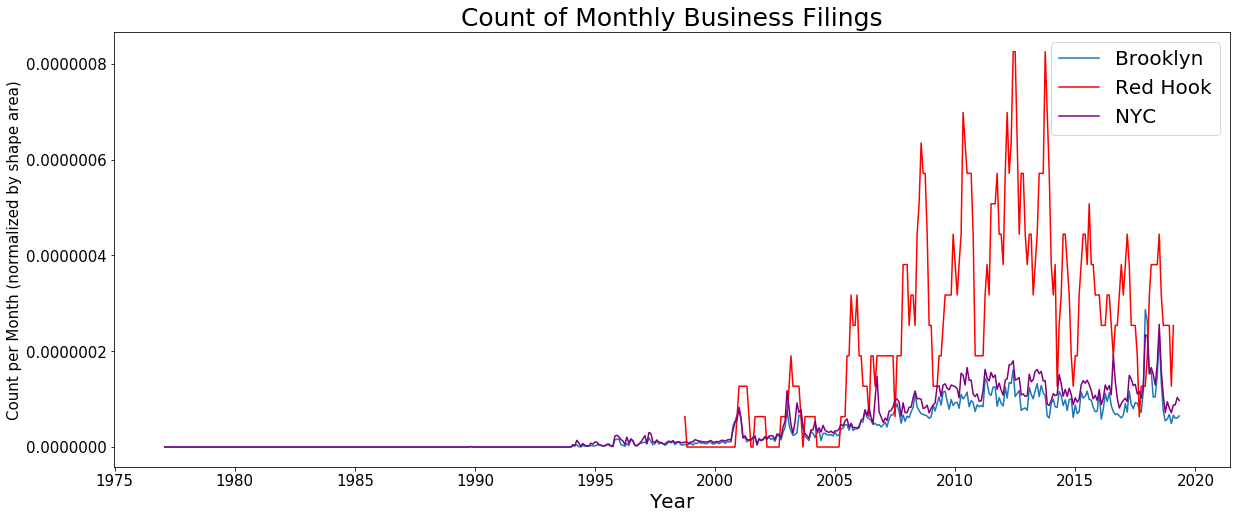

In [54]:
# Brooklyn and all of NYC
plt.figure(figsize=(20,8))
plt.plot(bk_merge['License Creation Date'], bk_merge['count_norm_area'], label='Brooklyn')
plt.plot(rh_merge['License Creation Date'], rh_merge['count_norm_area'].rolling(6).mean(), c='r', label='Red Hook')
plt.plot(file_count_merge['License Creation Date'], file_count_merge['count_norm_area'], c='purple', label='NYC')
plt.title("Count of Monthly Business Filings", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Count per Month (normalized by shape area)".format(norm_multiplier_pop), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.show()

In [55]:
# To modify the rolling mean window for Red Hook
rh_roller = 6
nyc_bk_roller = 1

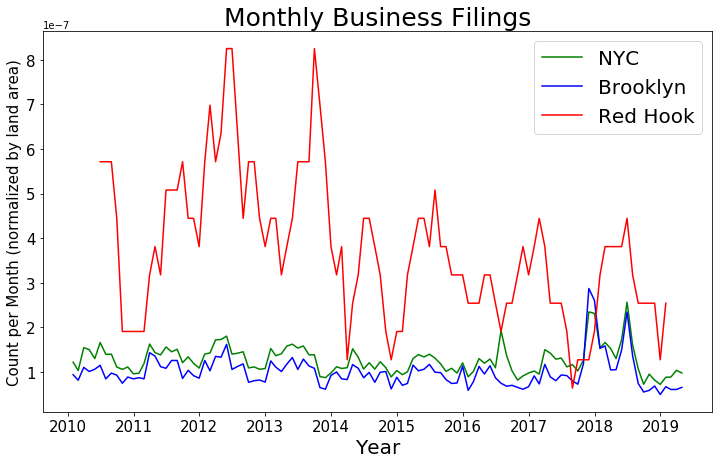

In [62]:
# Brooklyn and all of NYC
plt.figure(figsize=(12,7))
plt.plot(file_count_merge[file_count_merge['Year']>=2010]['License Creation Date'], \
         file_count_merge[file_count_merge['Year']>=2010]['count_norm_area'].rolling(nyc_bk_roller).mean(), \
         c='g', label='NYC')
plt.plot(bk_merge[bk_merge['Year']>=2010]['License Creation Date'], \
         bk_merge[bk_merge['Year']>=2010]['count_norm_area'].rolling(nyc_bk_roller).mean(), c='b', label='Brooklyn')
plt.plot(rh_merge[rh_merge['Year']>=2010]['License Creation Date'], \
         rh_merge[rh_merge['Year']>=2010]['count_norm_area'].rolling(rh_roller).mean(), c='r', label='Red Hook')
plt.title("Monthly Business Filings", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Count per Month (normalized by land area)".format(norm_multiplier_pop), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Above plot

This is the monthly count of business filings in different NYC geographies. Right now, the plot shows a rolling mean for Red Hook only with a window of 6 and Brooklyn & NYC with a window of 1. We could change this setting depending on what makes the most sense.

# Next steps

### Dana's list:

* Count per month per 100 residents > do per capita (you get 0.022 >> you'll have 2.2 per person, more perceivable) - done
* Top 5 industries: Laundry seems like corrupted data (nothing was there before 2017 and suddenly 1300 were filed?) so I would remove that one - done
* Normalize by area - done
* Rolling means - done (see plots)

### My list:

* Narrow down the business filings if you have time
* Deal with missing latitude and longitude if you have time